In [3]:
# 导入相关包
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from matplotlib.ticker import MultipleLocator
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import ensemble
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import VotingRegressor
import shap
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.metrics import max_error
from sklearn.preprocessing import StandardScaler
# 设置警告过滤器
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
import joblib
# ====================================================
# 1. 设置所有随机种子（关键步骤）
# ====================================================
def set_random_seeds(seed=24):
    random.seed(seed)          # Python内置随机种子
    np.random.seed(seed)       # NumPy随机种子
    tf.random.set_seed(seed)   # TensorFlow随机种子
    # 对于GPU使用的额外设置
    tf.config.experimental.enable_op_determinism()

set_random_seeds(42)  # 设置为任意固定值

# ====================================================
# 2. 加载数据（保持不变）
# ====================================================
excel_file = 'processed_data-selected-feature-16 -plus.xlsx'
df = pd.read_excel(excel_file)
category_column = df.iloc[:, 1]  # 类别索引列（从 0 开始的索引）
print(category_column)
# 获取类别的数量分布
category_counts = category_column.value_counts()
print("类别分布:\n", category_counts)
smiles_column = df['smiles'].astype(str).tolist()
y = df['LFS'].values

# special_condition = df.iloc[3750:3769, 4:30]  # 例如筛选 LFS 值大于 50 的数据
# print(special_condition)
# 3. 获取满足条件的索引
# special_indices = special_condition.index
# print(special_indices)
# ====================================================
# 3. One-Hot编码函数（保持不变）
# ====================================================
def smiles_to_one_hot(smiles_column):
    all_characters = set(''.join(smiles_column))
    char_to_index = {char: idx for idx, char in enumerate(sorted(all_characters))}
    max_len = max(len(smiles) for smiles in smiles_column)
    
    def encode_smiles(smiles):
        one_hot_matrix = np.zeros((max_len, len(char_to_index)), dtype=int)
        for i, char in enumerate(smiles):
            one_hot_matrix[i, char_to_index[char]] = 1
        return one_hot_matrix
    
    one_hot_list = [encode_smiles(smile) for smile in smiles_column]
    return np.array(one_hot_list), char_to_index, max_len

# 生成One-Hot编码
X_smiles, char_to_index, max_len = smiles_to_one_hot(smiles_column)
print("字符到索引的映射：", char_to_index)
# ====================================================
# 4. 数据标准化和划分（关键修改）
# ====================================================
descriptors_input = df.iloc[:,4:30]
scaler = StandardScaler()
X_descriptors = scaler.fit_transform(descriptors_input)
joblib.dump(scaler, 'fitted_scaler.pkl')
print("标准化器已保存到 'fitted_scaler.pkl'")
# 使用分层划分确保可复现性
category_column = df.iloc[:, 1]
train_idx, test_idx = [], []

for category in category_column.unique():
    category_data = df[category_column == category]
    
    # 如果该类别样本数为 1，直接划入训练集
    if len(category_data) == 1:
        train_idx.extend(category_data.index)
        print(f"类别 {category} 样本只有 1 个，直接划入训练集。")
    else:
        # 使用固定 random_state 和 stratify
        category_train, category_test = train_test_split(
            category_data.index,
            test_size=0.2,
            random_state=42,
            stratify=category_data[category_column.name]
        )
        train_idx.extend(category_train)
        test_idx.extend(category_test)



# indices_to_flip = [552, 562,826,868]  预测的时候有的是在测试集所以精度比较低把他们放进去了2016.1.14有感，可能之前程序跑出来不同的结果就是这样


# for idx in indices_to_flip:
#     if idx in test_idx:
#         test_idx.remove(idx)
#         train_idx.append(idx)
# 按索引提取数据
X_train_smiles, X_test_smiles = X_smiles[train_idx], X_smiles[test_idx]
# X_train_descriptors = scaler.transform(descriptors_input.iloc[train_idx])  # 注意使用transform
# X_test_descriptors = scaler.transform(descriptors_input.iloc[test_idx])
X_train_descriptors = X_descriptors[train_idx]
X_test_descriptors = X_descriptors[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
df['Dataset Split'] = 'Test'  # 默认所有数据为测试集
df.loc[train_idx, 'Dataset Split'] = 'Train'  # 将训练集的标记为 'Train'
# ====================================================
# 5. 构建确定性模型（关键修改）
# ====================================================
def create_deterministic_model(max_len, num_chars, descriptor_dim):
    smiles_input = Input(shape=(max_len, num_chars), name='smiles_input')
    descriptors_input = Input(shape=(descriptor_dim,), name='descriptors_input')
    
    # 使用固定初始化器
    x = Flatten()(smiles_input)
    x = Dense(16, 
              activation='relu',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
    
    merged = Concatenate()([x, descriptors_input])
    model = Model(inputs=[smiles_input, descriptors_input], outputs=merged)
    
    # 固定编译参数
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error'
    )
    return model

model = create_deterministic_model(
    max_len=max_len,
    num_chars=len(char_to_index),
    descriptor_dim=X_train_descriptors.shape[1]
)

# ====================================================
# 6. 获取确定性特征（关键修改）
# ====================================================
# 第一次运行会初始化权重，之后固定
X_train = model.predict([X_train_smiles, X_train_descriptors], verbose=0)
print(X_train.shape)
print(X_train)
X_test = model.predict([X_test_smiles, X_test_descriptors], verbose=0)
print(X_test.shape)


0       C1CCCCC1
1       C1CCCCC1
2       C1CCCCC1
3       C1CCCCC1
4       C1CCCCC1
          ...   
3749      CCCCCO
3750         C=C
3751        CC=C
3752       CCC=C
3753      C=CC=C
Name: smiles, Length: 3754, dtype: object
类别分布:
 smiles
CC(C)CC(C)(C)C        555
C                     467
CCC                   298
[HH]                  290
CCCCCCC               261
CCO                   246
CC                    187
CCCCCCCCCC            163
CCCCCO                162
CCCC                  153
CCCCC                 136
CC1CCCCC1             127
C1CCCCC1               88
CCCCO                  80
CO                     79
CC1=CC=CC=C1           67
CCCO                   62
CCCCCCCCCCCC           47
CCC1=CC=CC=C1          30
CCCCCCCCCCCCCC         28
CCC1CCCCC1             24
C1=CC=CC=C1            23
CCCC1=CC=CC=C1         22
CCCC1CCCCC1            22
CCCCC1=CC=CC=C1        19
CC1=CC(=CC=C1)C        17
CC1=CC(=CC(=C1)C)C     17
CC1=CC=CC=C1C          16
CCCCC1CCCCC1           10
CCC

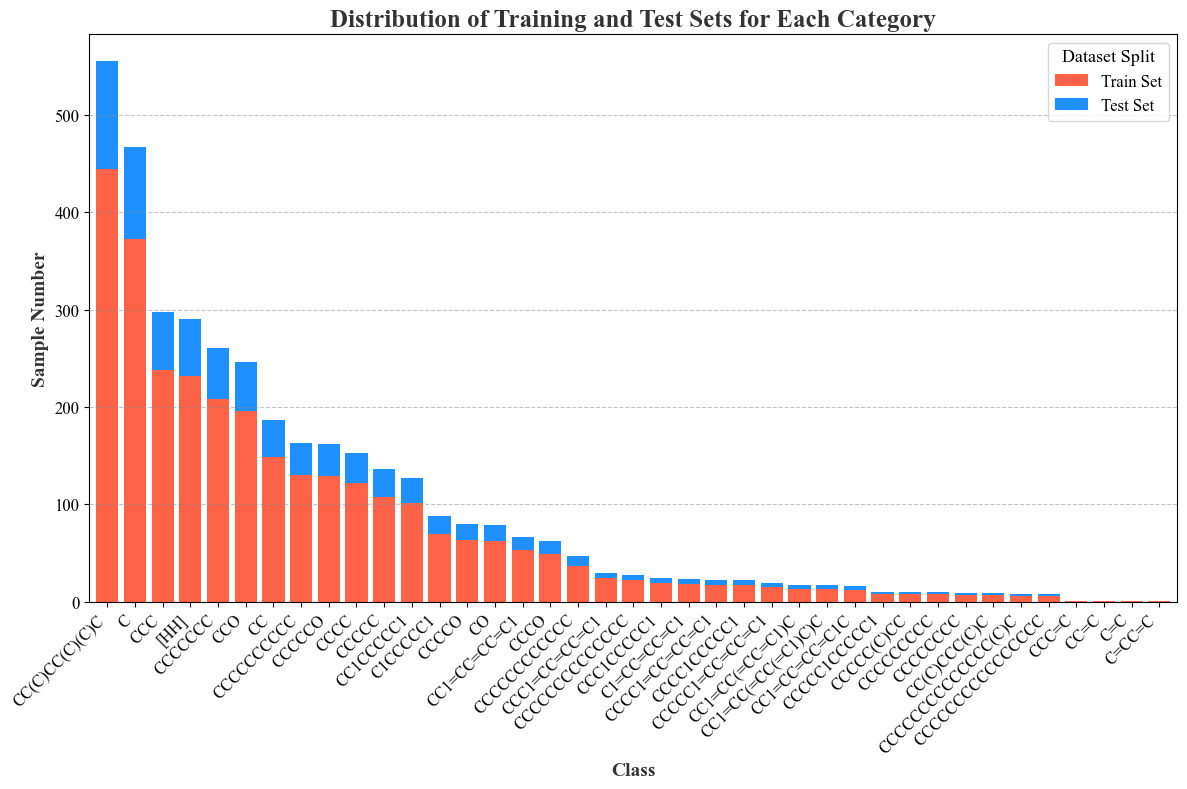

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 示例数据，假设 dataset 已经加载且包含 'Dataset Split' 和分类列
train_counts = df[df['Dataset Split'] == 'Train'].groupby(category_column.name).size()
test_counts = df[df['Dataset Split'] == 'Test'].groupby(category_column.name).size()

# 合并训练集和测试集的数量，填充缺失值为0
category_split_counts = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
}).fillna(0)

# 按照训练集和测试集的总数排序，确保中间是最多的
category_split_counts['Total'] = category_split_counts.sum(axis=1)
category_split_counts = category_split_counts.sort_values(by='Total', ascending=False)

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(12, 8))
category_split_counts.drop(columns='Total').plot(kind='bar', stacked=True, color=['#FF6347', '#1E90FF'], width=0.8, ax=ax)

# 设置标题和标签
plt.title('Distribution of Training and Test Sets for Each Category', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Class', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Sample Number', fontsize=14, fontweight='bold', color='#333333')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# 图例调整
plt.legend(title='Dataset Split', loc='upper right', labels=['Train Set', 'Test Set'], fontsize=12, title_fontsize=13)

# 添加网格线，使数据更易读
ax.grid(True, axis='y', linestyle='--', alpha=0.5, color='#888888')

# 调整布局以适应标签
plt.tight_layout()

# 显示图表
plt.show()


In [6]:
# ====================================================
# 7. 保存特征到Excel文件（修正版）
# ====================================================

# 创建包含所有特征的DataFrame
def save_features(features, indices, prefix):
    # 为每个特征创建列名 (feature_0, feature_1, ...)
    feature_cols = [f"{prefix}_feature_{i}" for i in range(features.shape[1])]
    return pd.DataFrame(features, columns=feature_cols, index=indices)

# 创建训练集和测试集特征DataFrame
train_features_df = save_features(X_train, train_idx, "train")
test_features_df = save_features(X_test, test_idx, "test")

# 合并到原始DataFrame
result_df = df.copy()
result_df = result_df.join(train_features_df, how='left')
result_df = result_df.join(test_features_df, how='left')

# 添加数据集类型标识列
result_df['dataset_type'] = 'train'
result_df.loc[test_idx, 'dataset_type'] = 'test'

# 保存到Excel
output_filename = "排错.xlsx"
result_df.to_excel(output_filename, index=False)
print(f"特征已保存到 {output_filename}")


特征已保存到 排错.xlsx


In [6]:
# best_xgboost = XGBRegressor(max_depth=4, n_estimators=250, random_state=42,learning_rate= 0.2,min_child_weight=4)
# best_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=100,  min_samples_split=5,random_state=42)
# best_LinearRegression = LinearRegression()
# best_RandomForestRegressor = RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100,random_state=42)
# best_svr = SVR(kernel='rbf', C=20000, gamma=0.1)
best_xgboost = XGBRegressor(max_depth=4, n_estimators=250, random_state=42,learning_rate= 0.25,min_child_weight=4)
best_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=100,  min_samples_split=5,random_state=42)
best_LinearRegression = LinearRegression()
best_RandomForestRegressor = RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100,random_state=42)
best_svr = SVR(kernel='rbf', C=30000, gamma=0.1)
# Train the best models on the entire training set
best_xgboost.fit(X_train, y_train)
best_GradientBoostingRegressor.fit(X_train, y_train)
best_LinearRegression.fit(X_train, y_train)
best_RandomForestRegressor.fit(X_train, y_train)
best_svr.fit(X_train, y_train)

# GradientBoostingRegressor
GradientBoostingRegressor_train_r2 = r2_score(y_train, best_GradientBoostingRegressor.predict(X_train))
GradientBoostingRegressor_train_rmse = np.sqrt(mean_squared_error(y_train, best_GradientBoostingRegressor.predict(X_train)))
GradientBoostingRegressor_test_r2 = r2_score(y_test, best_GradientBoostingRegressor.predict(X_test))
GradientBoostingRegressor_test_rmse = np.sqrt(mean_squared_error(y_test, best_GradientBoostingRegressor.predict(X_test)))
GradientBoostingRegressor_train_mae = mean_absolute_error(y_train, best_GradientBoostingRegressor.predict(X_train))
GradientBoostingRegressor_test_mae = mean_absolute_error(y_test, best_GradientBoostingRegressor.predict(X_test))

# LinearRegression
LinearRegression_train_r2 = r2_score(y_train, best_LinearRegression.predict(X_train))
LinearRegression_train_rmse = np.sqrt(mean_squared_error(y_train, best_LinearRegression.predict(X_train)))
LinearRegression_test_r2 = r2_score(y_test, best_LinearRegression.predict(X_test))
LinearRegression_test_rmse = np.sqrt(mean_squared_error(y_test, best_LinearRegression.predict(X_test)))
LinearRegression_train_mae = mean_absolute_error(y_train, best_LinearRegression.predict(X_train))
LinearRegression_test_mae = mean_absolute_error(y_test, best_LinearRegression.predict(X_test))

# RandomForestRegressor
RandomForestRegressor_train_r2 = r2_score(y_train, best_RandomForestRegressor.predict(X_train))
RandomForestRegressor_train_rmse = np.sqrt(mean_squared_error(y_train, best_RandomForestRegressor.predict(X_train)))
RandomForestRegressor_test_r2 = r2_score(y_test, best_RandomForestRegressor.predict(X_test))
RandomForestRegressor_test_rmse = np.sqrt(mean_squared_error(y_test, best_RandomForestRegressor.predict(X_test)))
RandomForestRegressor_train_mae = mean_absolute_error(y_train, best_RandomForestRegressor.predict(X_train))
RandomForestRegressor_test_mae = mean_absolute_error(y_test, best_RandomForestRegressor.predict(X_test))

# SVR
SVR_train_r2 = r2_score(y_train, best_svr.predict(X_train))
SVR_train_rmse = np.sqrt(mean_squared_error(y_train, best_svr.predict(X_train)))
SVR_test_r2 = r2_score(y_test, best_svr.predict(X_test))
SVR_test_rmse = np.sqrt(mean_squared_error(y_test, best_svr.predict(X_test)))
SVR_train_mae = mean_absolute_error(y_train, best_svr.predict(X_train))
SVR_test_mae = mean_absolute_error(y_test, best_svr.predict(X_test))

# XGBRegressor (assuming you have this model too)
xgboost_train_r2 = r2_score(y_train, best_xgboost.predict(X_train))
xgboost_train_rmse = np.sqrt(mean_squared_error(y_train, best_xgboost.predict(X_train)))
xgboost_test_r2 = r2_score(y_test, best_xgboost.predict(X_test))
xgboost_test_rmse = np.sqrt(mean_squared_error(y_test, best_xgboost.predict(X_test)))
xgboost_train_mae = mean_absolute_error(y_train, best_xgboost.predict(X_train))
xgboost_test_mae = mean_absolute_error(y_test, best_xgboost.predict(X_test))

# Printing Results
print("XGBRegressor train r2:", xgboost_train_r2)
print("XGBRegressor train RMSE:", xgboost_train_rmse)
print("XGBRegressor Test r2:", xgboost_test_r2)
print("XGBRegressor Test RMSE:", xgboost_test_rmse)
print("XGBRegressor train MAE:", xgboost_train_mae)
print("XGBRegressor Test MAE:", xgboost_test_mae)

print("GradientBoostingRegressor train r2:", GradientBoostingRegressor_train_r2)
print("GradientBoostingRegressor train RMSE:", GradientBoostingRegressor_train_rmse)
print("GradientBoostingRegressor Test r2:", GradientBoostingRegressor_test_r2)
print("GradientBoostingRegressor Test RMSE:", GradientBoostingRegressor_test_rmse)
print("GradientBoostingRegressor train MAE:", GradientBoostingRegressor_train_mae)
print("GradientBoostingRegressor Test MAE:", GradientBoostingRegressor_test_mae)

print("LinearRegression train r2:", LinearRegression_train_r2)
print("LinearRegression train RMSE:", LinearRegression_train_rmse)
print("LinearRegression Test r2:", LinearRegression_test_r2)
print("LinearRegression Test RMSE:", LinearRegression_test_rmse)
print("LinearRegression train MAE:", LinearRegression_train_mae)
print("LinearRegression Test MAE:", LinearRegression_test_mae)

print("RandomForestRegressor train r2:", RandomForestRegressor_train_r2)
print("RandomForestRegressor train RMSE:", RandomForestRegressor_train_rmse)
print("RandomForestRegressor Test r2:", RandomForestRegressor_test_r2)
print("RandomForestRegressor Test RMSE:", RandomForestRegressor_test_rmse)
print("RandomForestRegressor train MAE:", RandomForestRegressor_train_mae)
print("RandomForestRegressor Test MAE:", RandomForestRegressor_test_mae)

print("SVR train r2:", SVR_train_r2)
print("SVR train RMSE:", SVR_train_rmse)
print("SVR Test r2:", SVR_test_r2)
print("SVR Test RMSE:", SVR_test_rmse)
print("SVR train MAE:", SVR_train_mae)
print("SVR Test MAE:", SVR_test_mae)


XGBRegressor train r2: 0.9964066757822111
XGBRegressor train RMSE: 3.0897286109319726
XGBRegressor Test r2: 0.9920220179470164
XGBRegressor Test RMSE: 4.983145800848343
XGBRegressor train MAE: 1.9119255795393177
XGBRegressor Test MAE: 2.80063444375971
GradientBoostingRegressor train r2: 0.9954575122566995
GradientBoostingRegressor train RMSE: 3.4739136116453135
GradientBoostingRegressor Test r2: 0.9908294057039649
GradientBoostingRegressor Test RMSE: 5.342638718755652
GradientBoostingRegressor train MAE: 2.256366714488289
GradientBoostingRegressor Test MAE: 3.0780196846934067
LinearRegression train r2: 0.6645675909775146
LinearRegression train RMSE: 29.852083166159794
LinearRegression Test r2: 0.6439628081277233
LinearRegression Test RMSE: 33.28930669141656
LinearRegression train MAE: 16.008496736819115
LinearRegression Test MAE: 17.64165627392813
RandomForestRegressor train r2: 0.9862415079630507
RandomForestRegressor train RMSE: 6.045852543429814
RandomForestRegressor Test r2: 0.9783

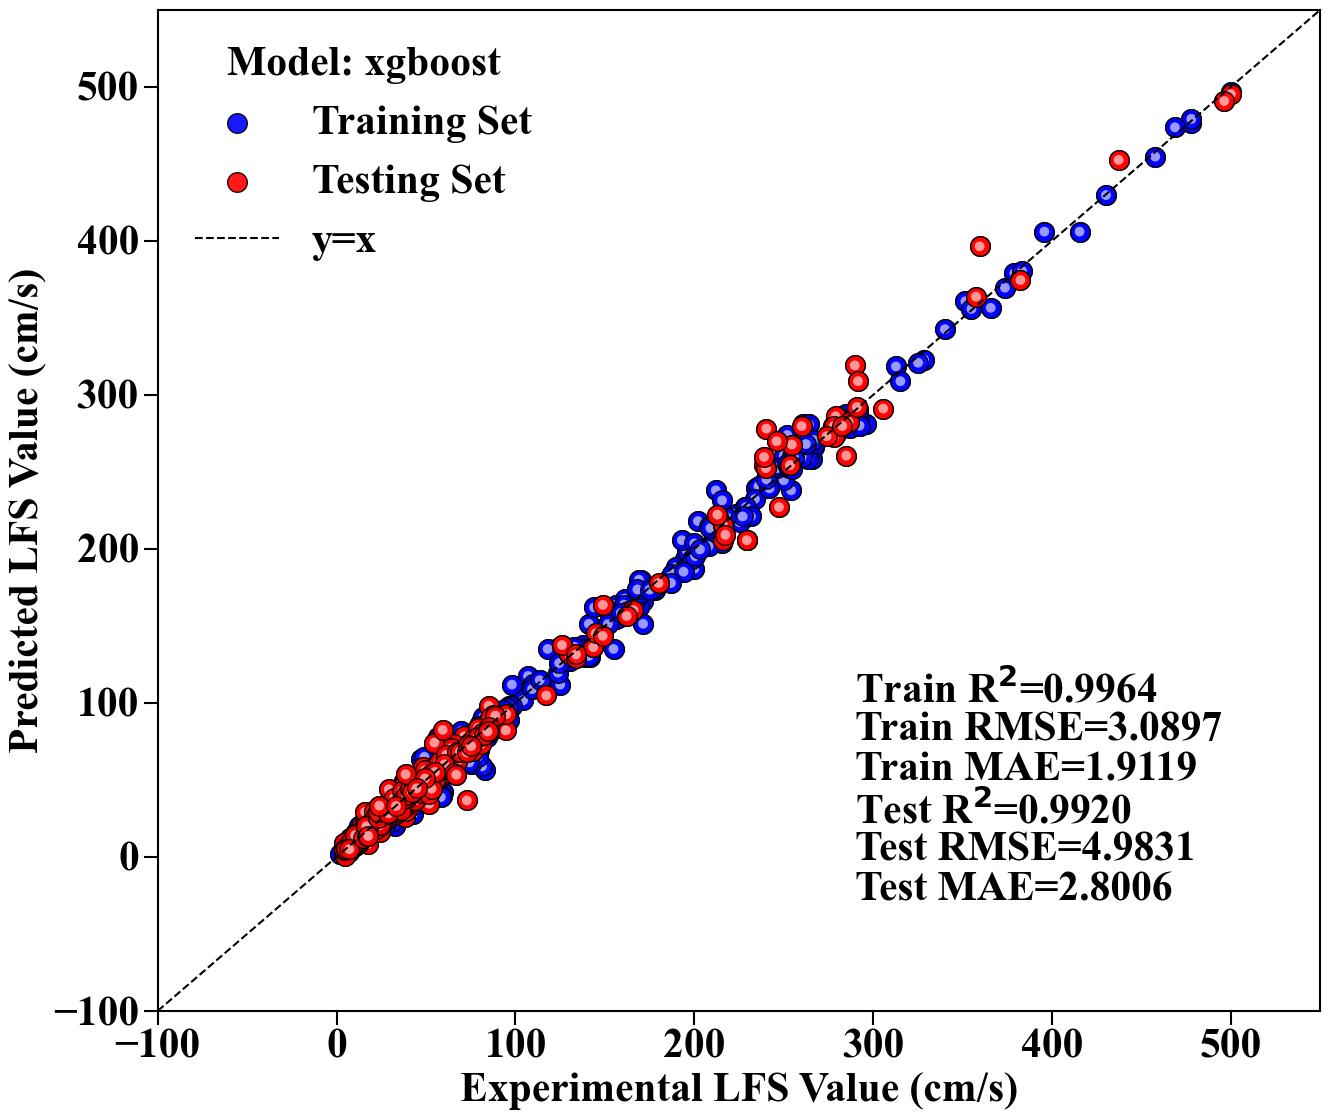

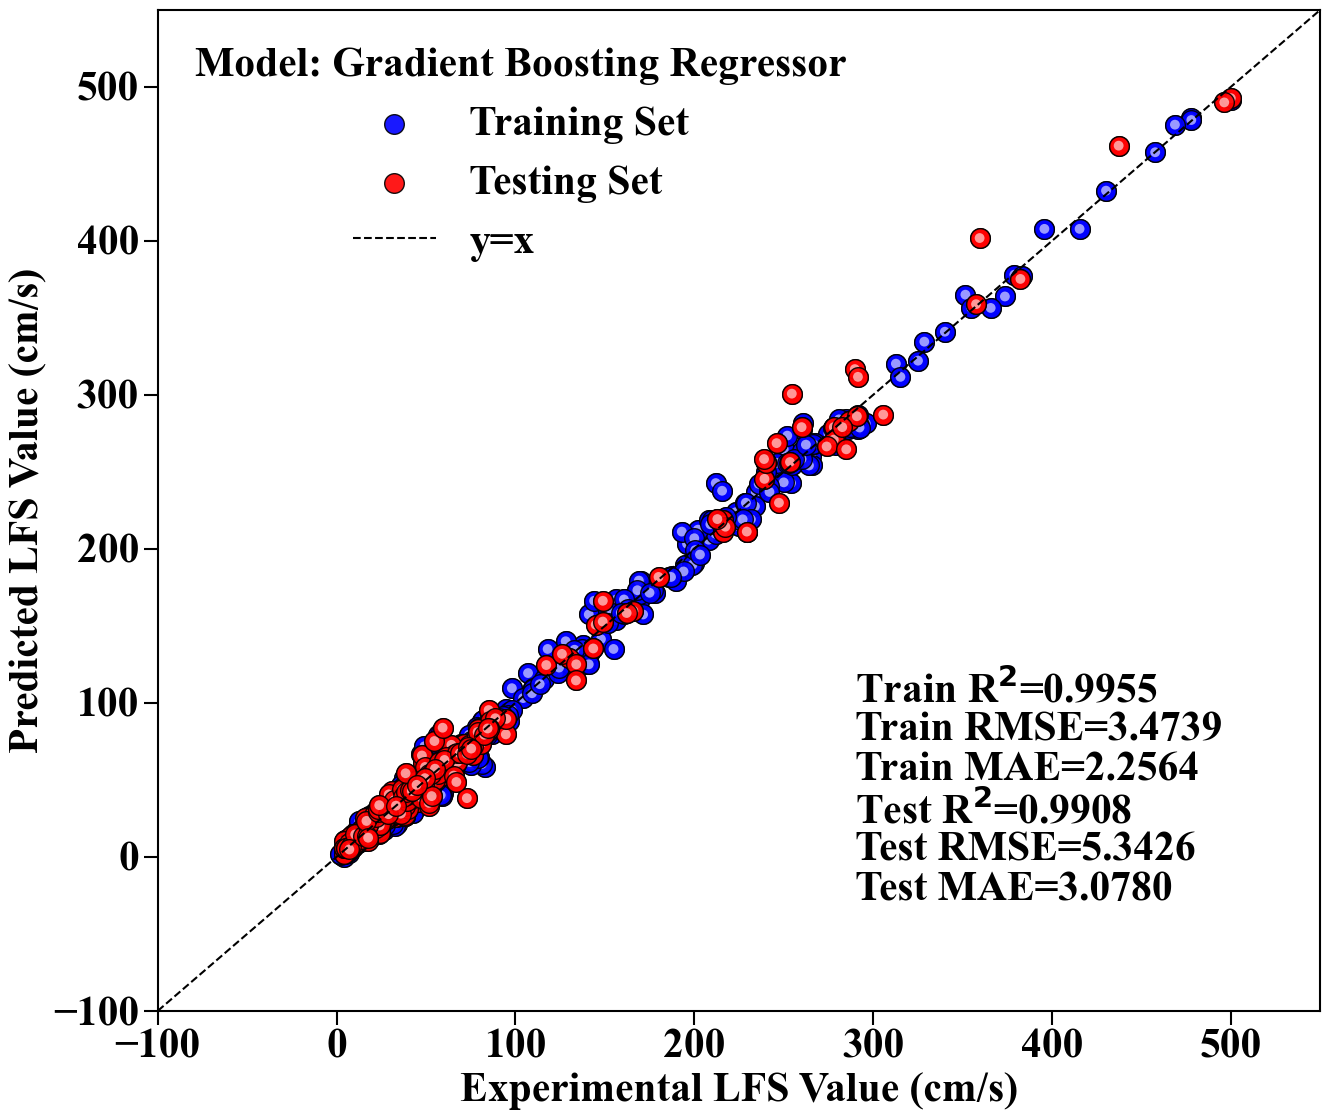

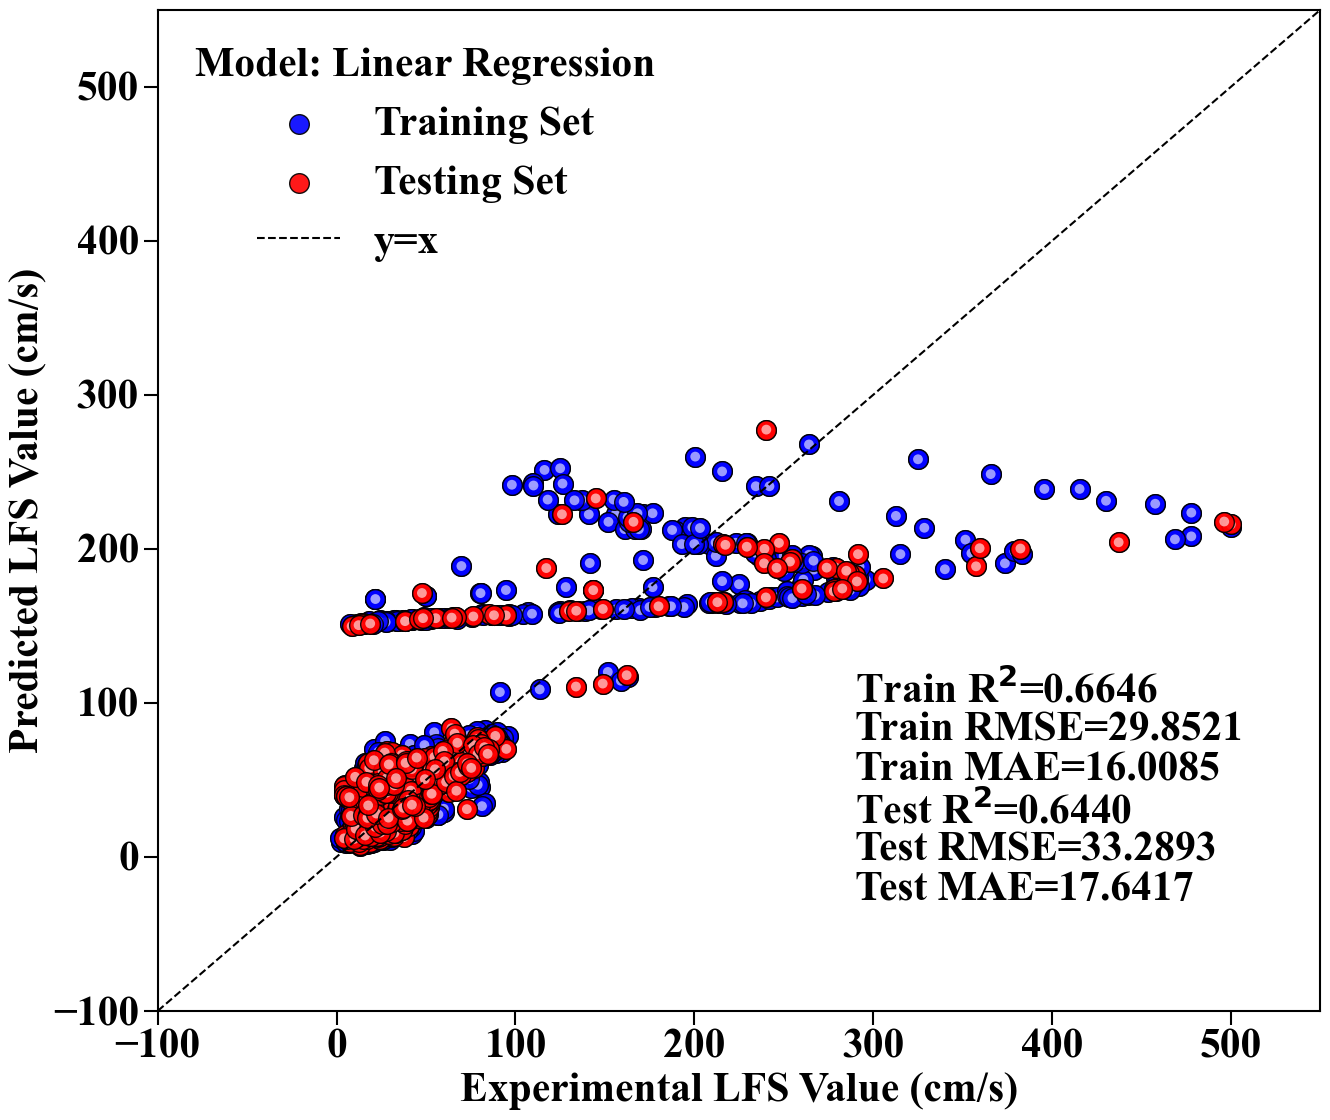

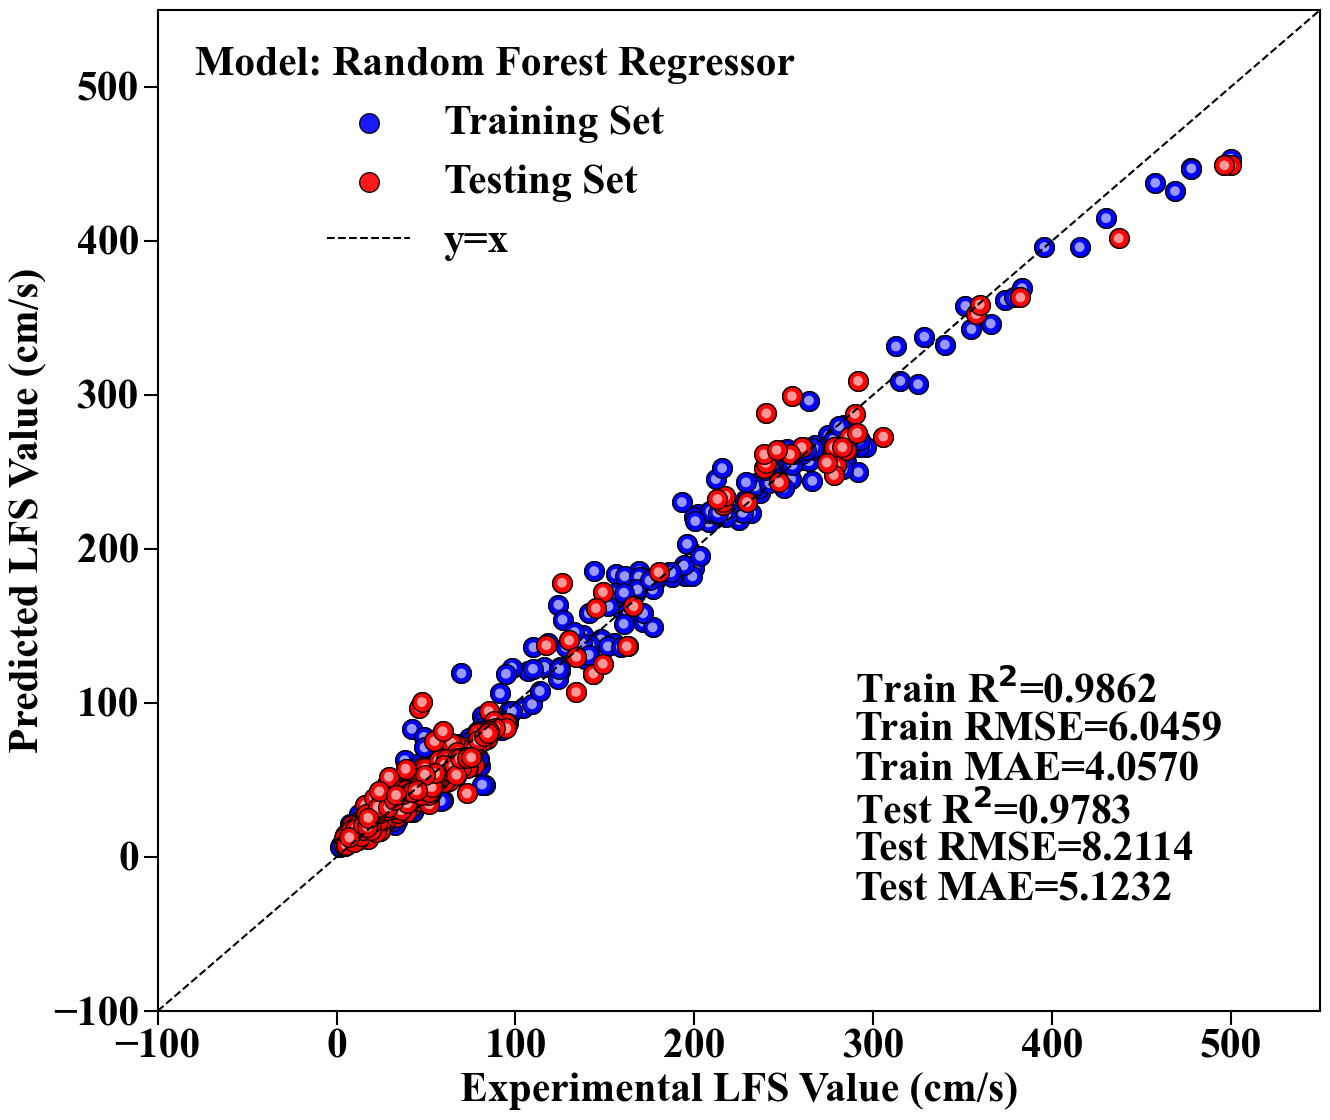

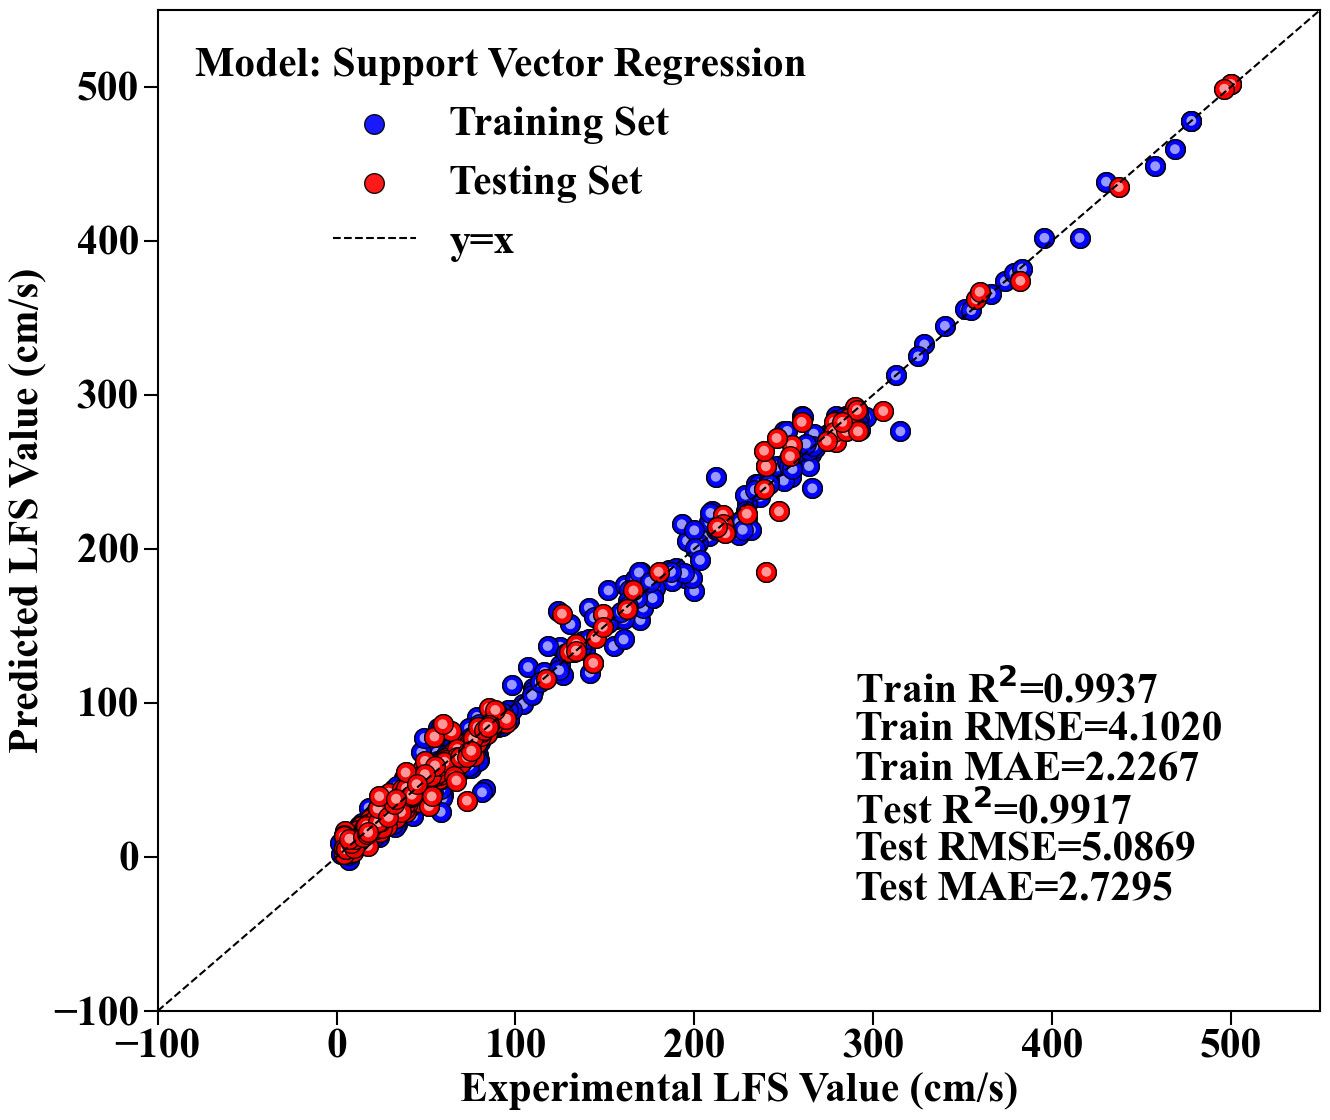

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
models = [best_xgboost, best_GradientBoostingRegressor, best_LinearRegression, best_RandomForestRegressor,best_svr]
names = ['xgboost', 'Gradient Boosting Regressor', 'Linear Regression', 'Random Forest Regressor','Support Vector Regression']
for model, name in zip(models, names):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_score = r2_score(y_train, train_pred)
    test_score = r2_score(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_MAE = mean_absolute_error(y_train, train_pred)
    test_MAE = mean_absolute_error(y_test, test_pred)
    plt.figure(figsize=(15, 13))
    plt.clf()

    # 设置坐标轴标签
    plt.xlabel('Experimental LFS Value (cm/s)', fontsize=30, weight='bold')
    plt.ylabel('Predicted LFS Value (cm/s)', fontsize=30, weight='bold')
    plt.xticks(fontsize=30, weight='bold')
    plt.yticks(fontsize=30, weight='bold')

    # 绘制网格线
    #plt.grid(True, linestyle='--', alpha=1)

    # 绘制训练集和测试集的散点图，添加立体效果
    def plot_3d_scatter(x, y, ax, color, label, marker):
        # 绘制渐变色的点
        scatter = ax.scatter(x, y, color=color, edgecolor='black', label=label, s=200, alpha=0.9, marker=marker)
        # 添加高光效果
        for i in range(len(x)):
            ax.scatter(x[i], y[i], color=color, edgecolor='black', s=200, alpha=0.9, marker=marker)
            ax.scatter(x[i], y[i], color='white', edgecolor='none', s=50, alpha=0.6, marker=marker)

    ax = plt.gca()
    # 绘制训练集散点图
    plot_3d_scatter(y_train, train_pred, ax, 'blue', 'Training Set', 'o')
    # 绘制测试集散点图
    plot_3d_scatter(y_test, test_pred, ax, 'red', 'Testing Set', 'o')
    # 绘制y=x参考线
    # # 设置坐标轴范围
    plt.xlim(left=-100, right=550)  # 设置横坐标从 100 到 500
    plt.ylim(bottom=-100, top=550)  # 设置纵坐标从 100 到 800

    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.ylim()[0], plt.ylim()[1]], color='black', linestyle='--', label='y=x')

    # 在图例框中添加额外的信息
    extra_info = f'Model: {name}'
    plt.legend(loc='upper left', title=extra_info, prop={'size': 30}, title_fontsize='30', frameon=False)

    # 在图中右下角添加指定文本
    plt.text(0.6, 0.32, f"Train R$^{{2}}$={train_score:.4f}", fontsize=30, ha='left',weight='bold', va='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.28, f"Train RMSE={train_rmse:.4f}", fontsize=30, ha='left',weight='bold', va='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.24, f"Train MAE={train_MAE:.4f}", fontsize=30, ha='left',weight='bold', va='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.20, f"Test R$^{{2}}$={test_score:.4f}", fontsize=30, ha='left',weight='bold', va='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.16, f"Test RMSE={test_rmse:.4f}", fontsize=30, ha='left',weight='bold', va='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.12, f"Test MAE={test_MAE:.4f}", fontsize=30, ha='left', weight='bold', va='center', transform=plt.gca().transAxes)
    # 加粗边框
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    plt.tick_params(width=1.5,length=10)#修改刻度线线粗细width参数，修改刻度字体labelsize参数

    # 显示图形
    plt.show()

Ensemble Test Accuracy: 0.9938
The mean squared error (MSE) on train set: 3.3497
The mean squared error (MSE) on test set: 4.3752
The R² on train set: 0.9958
The R² on test set: 0.9938
The ME on train set: 32.5716
The ME on test set: 36.2387
The MAE on train set: 1.9323
The MAE on test set: 2.4907


<Figure size 640x480 with 0 Axes>

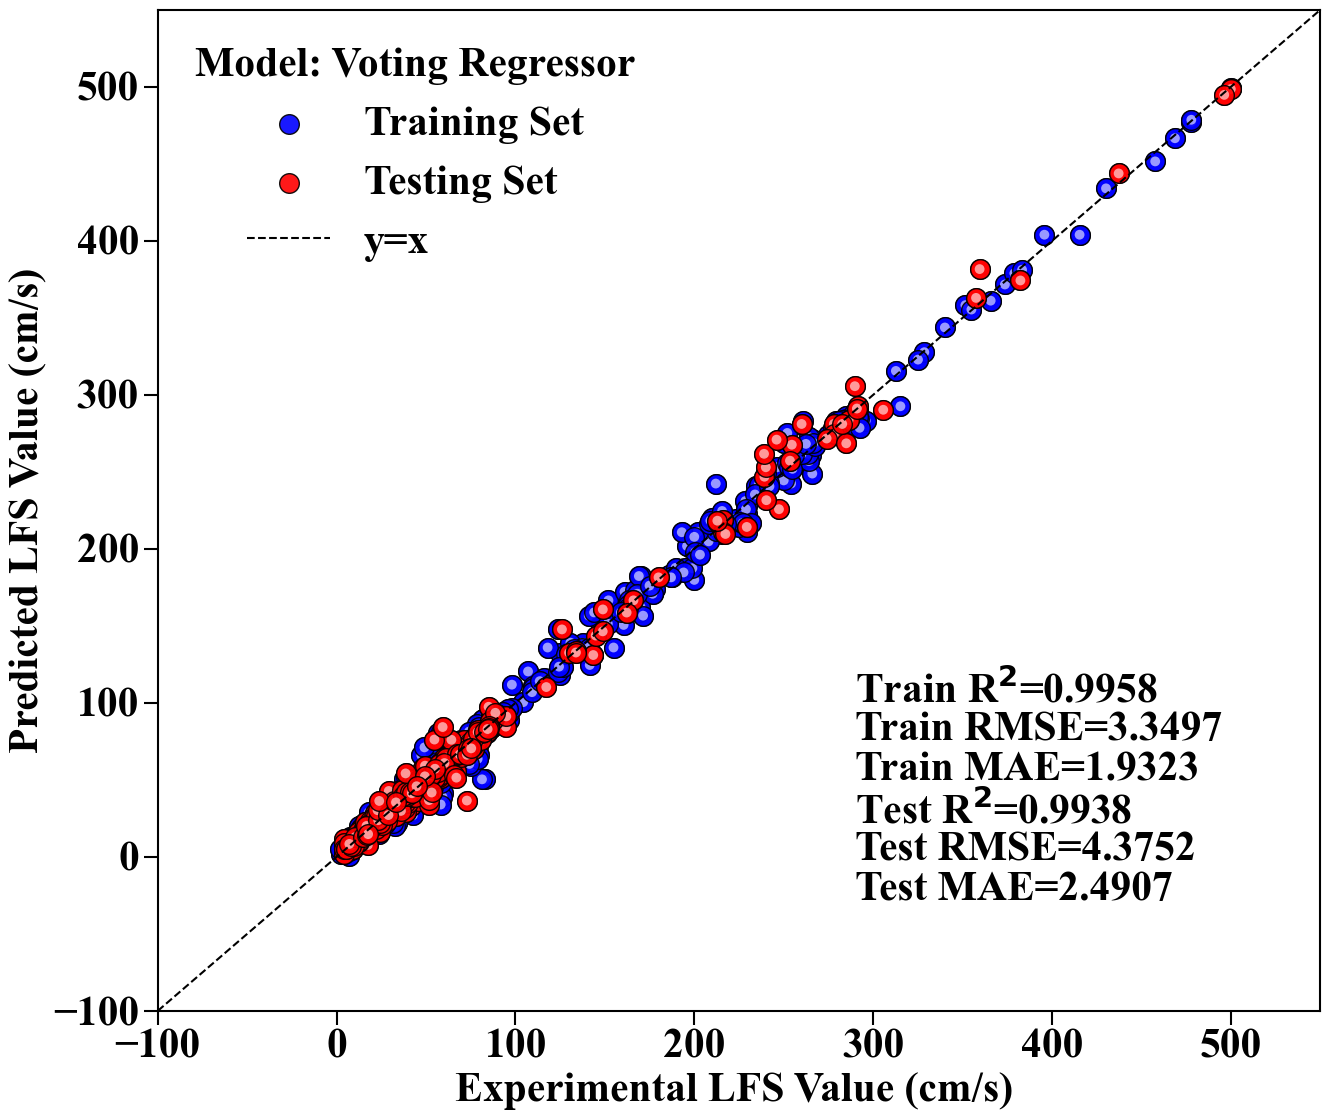

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, max_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold

# 设置字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 14

# 定义集成模型
estimators = [('xgboost', best_xgboost), 
              ('GradientBoostingRegressor', best_GradientBoostingRegressor), 
              ('LinearRegression', best_LinearRegression),
              ('RandomForestRegressor', best_RandomForestRegressor),
              ('SVR', best_svr)]
# weights = [0.4,0.1,0,0.0,0.5]  # 分配的权重和应该相加等于1
weights = [0.5,0.0,0,0.0,0.5]
# 创建VotingRegressor
ensemble_model = VotingRegressor(estimators=estimators, weights=weights)

# 训练集成模型
ensemble_model.fit(X_train, y_train)

# 在测试集上评估集成模型并打印准确度分数
ensemble_test_accuracy = ensemble_model.score(X_test, y_test)  # 回归问题中返回的就是R²
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy:.4f}")

# 计算MSE和R²
ensemble_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_model.predict(X_train)))
ensemble_test_rmse = np.sqrt(mean_squared_error(y_test, ensemble_model.predict(X_test)))
ensemble_train_score = ensemble_model.score(X_train, y_train)
ensemble_test_score = ensemble_model.score(X_test, y_test)
ensemble_train_me = max_error(y_train, ensemble_model.predict(X_train))
ensemble_test_me = max_error(y_test, ensemble_model.predict(X_test))
ensemble_train_mae = mean_absolute_error(y_train, ensemble_model.predict(X_train))
ensemble_test_mae = mean_absolute_error(y_test, ensemble_model.predict(X_test))
print("The mean squared error (MSE) on train set: {:.4f}".format(ensemble_train_rmse))
print("The mean squared error (MSE) on test set: {:.4f}".format(ensemble_test_rmse))
print("The R² on train set: {:.4f}".format(ensemble_train_score))
print("The R² on test set: {:.4f}".format(ensemble_test_score))
print("The ME on train set: {:.4f}".format(ensemble_train_me))
print("The ME on test set: {:.4f}".format(ensemble_test_me))
print("The MAE on train set: {:.4f}".format(ensemble_train_mae))
print("The MAE on test set: {:.4f}".format(ensemble_test_mae))

# # 对模型进行交叉验证并计算平均分数
# rmse_scorer = make_scorer(mean_squared_error, squared=False)
# r2_scorer = make_scorer(r2_score)
# ME_scorer = make_scorer(max_error)
# kf = KFold(n_splits=10, shuffle=True, random_state=52)
# scores1 = cross_val_score(ensemble_model, X_train, y_train, cv=kf, scoring=rmse_scorer)
# scores2 = cross_val_score(ensemble_model, X_train, y_train, cv=kf, scoring='r2')
# scores3 = cross_val_score(ensemble_model, X_train, y_train, cv=kf, scoring=ME_scorer)

# print(scores1)
# print(scores2)
# print(scores3)

# average_score1 = np.mean(scores1)
# average_score2 = np.mean(scores2)
# average_score3 = np.mean(scores3)

# print("Cross-validated RMSE scores:", average_score1)
# print("Cross-validated r2 scores:", average_score2)
# print("Cross-validated ME scores:", average_score3)

# 清除当前图形
plt.clf()
plt.figure(figsize=(15, 13))

# 设置坐标轴标签和刻度
plt.xlabel('Experimental LFS Value (cm/s) ', fontsize=30, weight='bold')
plt.ylabel('Predicted LFS Value (cm/s)', fontsize=30, weight='bold')
plt.xticks(fontsize=30, weight='bold')
plt.yticks(fontsize=30, weight='bold')

# 绘制散点图
def plot_3d_scatter(x, y, ax, color, label, marker):
    scatter = ax.scatter(x, y, color=color, edgecolor='black', label=label, s=200, alpha=0.9, marker=marker)
    # 添加高光效果
    for i in range(len(x)):
        ax.scatter(x[i], y[i], color=color, edgecolor='black', s=200, alpha=0.9, marker=marker)
        ax.scatter(x[i], y[i], color='white', edgecolor='none', s=50, alpha=0.6, marker=marker)

# 绘制训练集和测试集的散点图
plot_3d_scatter(y_train, ensemble_model.predict(X_train), plt, 'blue', 'Training Set', 'o')
plot_3d_scatter(y_test, ensemble_model.predict(X_test), plt, 'red', 'Testing Set', 'o')

# 设置坐标轴范围
plt.xlim(left=-100, right=550)  # 设置横坐标从 100 到 500
plt.ylim(bottom=-100, top=550)  # 设置纵坐标从 100 到 800
# 绘制y=x参考线
plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.ylim()[0], plt.ylim()[1]], color='black', linestyle='--', label='y=x')

# 在图例框中添加额外的信息
extra_info = 'Model: Voting Regressor'
plt.legend(loc='upper left', title=extra_info, prop={'size': 30, 'weight': 'bold'}, title_fontsize='30', frameon=False)

# 在图中右下角添加指定文本
plt.text(0.6, 0.32, f"Train R$^{{2}}$={ensemble_train_score:.4f}", fontsize=30, weight='bold', ha='left', va='center', transform=plt.gca().transAxes)
plt.text(0.6, 0.28, f"Train RMSE={ensemble_train_rmse:.4f}", fontsize=30, weight='bold', ha='left', va='center', transform=plt.gca().transAxes)
plt.text(0.6, 0.24, f"Train MAE={ensemble_train_mae:.4f}", fontsize=30, weight='bold', ha='left', va='center', transform=plt.gca().transAxes)

plt.text(0.6, 0.20, f"Test R$^{{2}}$={ensemble_test_score:.4f}", fontsize=30, weight='bold', ha='left', va='center', transform=plt.gca().transAxes)
plt.text(0.6, 0.16, f"Test RMSE={ensemble_test_rmse:.4f}", fontsize=30, weight='bold', ha='left', va='center', transform=plt.gca().transAxes)
plt.text(0.6, 0.12, f"Test MAE={ensemble_test_mae:.4f}", fontsize=30, weight='bold', ha='left', va='center', transform=plt.gca().transAxes)

# 加粗边框
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(width=1.5,length=10)

In [8]:
# 使用joblib保存整个模型
import joblib
joblib.dump(ensemble_model, 'voting_regressor_model-LFS-3754.pkl')
print("集成模型已保存到 'voting_regressor_model-LFS-3754.pkl'")

集成模型已保存到 'voting_regressor_model-LFS-3754.pkl'


In [30]:
#没有归一化
# 读取新的 Excel 数据（例如，特征列）
file_path = '预测数据集.xlsx'  # 请替换为新数据的文件路径
df_new = pd.read_excel(file_path)
# print(df_new)
X_new =df_new.iloc[:,9:41] 
# 标准化描述符数据
print(X_new.shape)
# 使用训练好的模型进行预测
y_pred_new = ensemble_model.predict(X_new)

# 输出预测结果
print(f'预测结果: {y_pred_new}')
# 将预测结果添加到 DataFrame 中，假设我们添加到 'Predicted_LFS' 列
print("逐行打印预测结果:")
for idx, prediction in enumerate(y_pred_new):
    print(f' {prediction}')

(27, 32)
预测结果: [34.9496563  42.58245144 40.02592303 42.55375274 40.20140694 59.04404589
 37.62697003 46.01739176 66.55143158 38.30855874 39.35595203 34.10507539
 35.99421407 43.5871489  53.70993342 40.88979897 37.73473497 43.62270909
 47.84616124 47.26714609 46.61179029 51.28056928 47.76439238 61.71573117
 41.24592732 43.55945077 51.82650964]
逐行打印预测结果:
 34.94965630061602
 42.582451437526984
 40.02592302524653
 42.55375274120963
 40.20140693956762
 59.04404588711128
 37.626970034953395
 46.01739175534136
 66.55143158205738
 38.30855874215168
 39.355952032341285
 34.10507539199374
 35.99421406613353
 43.58714889802576
 53.70993341751661
 40.88979896605902
 37.73473496920412
 43.622709086043514
 47.8461612355205
 47.26714609156808
 46.61179029025832
 51.280569284000485
 47.764392382716295
 61.71573116595642
 41.245927322387416
 43.559450771247164
 51.826509638713794


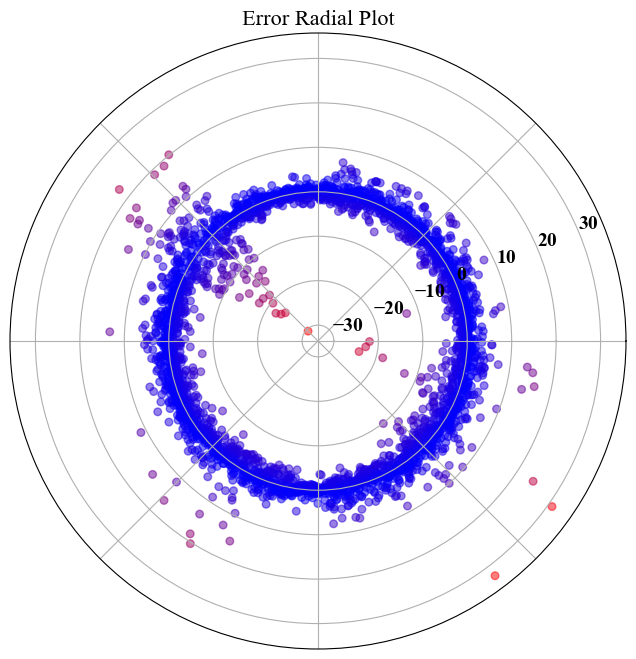

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 预测结果
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 计算误差
train_errors = y_train - y_train_pred
test_errors = y_test - y_test_pred

# 合并数据用于辐射图
# all_y = np.concatenate([y_train, y_test])
# all_errors = np.concatenate([train_errors, test_errors])

# 计算角度和半径
angles = np.linspace(0, 2 * np.pi, len(y_train), endpoint=False)
radii = train_errors

# 创建辐射图
plt.figure(figsize=(8, 8))

# 设置极坐标
ax = plt.subplot(111, projection='polar')

# 根据误差大小，设置点的颜色
cmap = LinearSegmentedColormap.from_list('error_cmap', ['red', 'blue', 'red'])
colors = [cmap((error - min(radii)) / (max(radii) - min(radii))) for error in radii]

# 绘制散点图
ax.scatter(angles, radii, c=colors, alpha=0.5, s=30, label="Errors")

# 设置标题
plt.title("Error Radial Plot", fontsize=16)

# 添加参考线（误差为0的地方）
ax.axhline(0, color='black', linestyle='--')

# 设置轴标签
# ax.set_xlabel("True Values", fontsize=12)
# ax.set_ylabel("Error", fontsize=12)
# 去掉极坐标的角度刻度
ax.set_xticklabels([])  # 去掉角度轴上的标签
plt.show()




In [23]:
import pandas as pd

# 预测结果
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 假设原始的 Excel 文件名为 'processed_data-selected-feature-16.xlsx'
file_path = 'processed_data-selected-feature-16.xlsx'

# 读取原有的 Excel 文件
df = pd.read_excel(file_path)
# 将预测结果添加到对应的索引位置
df.loc[train_idx, 'y_train'] = y_train
df.loc[test_idx, 'y_test'] = y_test

df.loc[train_idx, 'y_train_pred'] = y_train_pred
df.loc[test_idx, 'y_test_pred'] = y_test_pred

# 保存回 Excel 文件，覆盖原文件或保存为新文件
df.to_excel('processed_data-selected-feature-16-results.xlsx', index=False)

print("预测结果已成功添加到原始 Excel 文件中。")


预测结果已成功添加到原始 Excel 文件中。


In [14]:
import pandas as pd

# 假设 ensemble_model 已经训练好了，X_train, X_test 也准备好了
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 假设原始的 Excel 文件名为 'processed_data-selected-feature-16.xlsx'
file_path = 'processed_data-selected-feature-16 -plus.xlsx'

# 读取原有的 Excel 文件
df = pd.read_excel(file_path)

# 将预测结果添加到对应的索引位置
df.loc[train_idx, 'y_pred'] = y_train_pred
df.loc[test_idx, 'y_pred'] = y_test_pred
# 在原 dataset 上添加一个新的列来标记训练集和测试集
df['Dataset Split'] = 'Test'  # 默认所有数据为测试集
df.loc[train_idx, 'Dataset Split'] = 'Train'  # 将训练集的标记为 'Train'
# 保存回 Excel 文件，覆盖原文件或保存为新文件
df.to_excel('processed_data-selected-feature-16-results-3754.xlsx', index=False)

print("预测结果已成功添加到原始 Excel 文件中。")


预测结果已成功添加到原始 Excel 文件中。


In [25]:

import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# 读取原有的 Excel 文件
file_path = 'processed_data-selected-feature-16-results-3754.xlsx'
df = pd.read_excel(file_path)
pred = df['y_pred']
target = df['LFS']

category_column = df.iloc[:, 1]  # 类别索引列（从 0 开始的索引）
print(category_column)
# 获取类别的数量分布
category_counts = category_column.value_counts()
# 初始化一个列表来存储结果
results = []
train_idx, test_idx = [], []
# 为每个类别进行分层划分
for category in category_column.unique():
    category_data = df[category_column == category]
    
    # 如果该类别样本数为 1，直接划入训练集
    if len(category_data) == 1:
        train_idx.extend(category_data.index)
        print(f"类别 {category} 样本只有 1 个，直接划入训练集。")
    else:
        # 使用固定 random_state 和 stratify
        category_train, category_test = train_test_split(
            category_data.index,
            test_size=0.2,
            random_state=42,
            stratify=category_data[category_column.name]
        )
        train_idx.extend(category_train)
        test_idx.extend(category_test)

    # 获取训练集和测试集的预测值和真实值
    y_train_pred = pred.loc[train_idx]
    y_train = target.loc[train_idx]
    y_test_pred = pred.loc[test_idx]
    y_test = target.loc[test_idx]
    
    # 计算训练集和测试集的 R² 和 RMSE
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # 将结果添加到结果列表
    results.append({
        'Category': category,
        'Train_R²': train_r2,
        'Train_RMSE': train_rmse,
        'Test_R²': test_r2,
        'Test_RMSE': test_rmse,
        'category_counts': category_counts[category]
    })

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)

# 保存到新的 Excel 文件
output_path = 'model_each_category_performance_results-3754-2.xlsx'
results_df.to_excel(output_path, index=False)

print(f"Results saved to {output_path}")


0       C1CCCCC1
1       C1CCCCC1
2       C1CCCCC1
3       C1CCCCC1
4       C1CCCCC1
          ...   
3749      CCCCCO
3750         C=C
3751        CC=C
3752       CCC=C
3753      C=CC=C
Name: smiles, Length: 3754, dtype: object
类别 C=C 样本只有 1 个，直接划入训练集。
类别 CC=C 样本只有 1 个，直接划入训练集。
类别 CCC=C 样本只有 1 个，直接划入训练集。
类别 C=CC=C 样本只有 1 个，直接划入训练集。
Results saved to model_each_category_performance_results-3754-2.xlsx


In [28]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# 读取原有的 Excel 文件
file_path = 'processed_data-selected-feature-16-results-3754.xlsx'
df = pd.read_excel(file_path)
pred = df['y_pred']
target = df['LFS']

category_column = df.iloc[:, 1]
category_counts = category_column.value_counts()
results = []

# 为每个类别进行分层划分
for category in category_column.unique():
    category_data = df[category_column == category]
    
    if len(category_data) == 1:
        train_indices = category_data.index
        test_indices = []
        print(f"类别 {category} 样本只有 1 个，直接划入训练集。")
    else:
        # 分层划分
        train_indices, test_indices = train_test_split(
            category_data.index,
            test_size=0.2,
            random_state=42,
            stratify=category_data[category_column.name]
        )
    
    # 关键修改：只使用当前类别的数据
    y_train_pred = pred.loc[train_indices]
    y_train = target.loc[train_indices]
    
    # 检查是否有测试集数据
    if len(test_indices) > 0:
        y_test_pred = pred.loc[test_indices]
        y_test = target.loc[test_indices]
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    else:
        test_r2 = np.nan
        test_rmse = np.nan
    
    # 检查训练集是否有足够样本计算R²
    if len(train_indices) >= 2:
        train_r2 = r2_score(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    else:
        train_r2 = np.nan
        train_rmse = np.nan
    
    # 将结果添加到结果列表
    results.append({
        'Category': category,
        'Train_R²': train_r2,
        'Train_RMSE': train_rmse,
        'Test_R²': test_r2,
        'Test_RMSE': test_rmse,
        'Sample_Count': len(category_data),
        'Train_Count': len(train_indices),
        'Test_Count': len(test_indices)
    })

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)

# 保存到新的 Excel 文件
output_path = 'corrected_model_each_category_performance_results.xlsx'
results_df.to_excel(output_path, index=False)

print(f"修正后的结果已保存到 {output_path}")

# 验证：比较两个程序的结果差异
print("\n=== 验证两个程序计算的差异 ===")
print("第二个程序（正确）计算的是每个类别独立的数据")
print("第一个程序（错误）计算的是累计混合数据的指标")

类别 C=C 样本只有 1 个，直接划入训练集。
类别 CC=C 样本只有 1 个，直接划入训练集。
类别 CCC=C 样本只有 1 个，直接划入训练集。
类别 C=CC=C 样本只有 1 个，直接划入训练集。
修正后的结果已保存到 corrected_model_each_category_performance_results.xlsx

=== 验证两个程序计算的差异 ===
第二个程序（正确）计算的是每个类别独立的数据
第一个程序（错误）计算的是累计混合数据的指标


In [29]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# 读取原有的 Excel 文件
file_path = 'processed_data-selected-feature-16-results-3754.xlsx'
df = pd.read_excel(file_path)
pred = df['y_pred']
target = df['LFS']

category_column = df.iloc[:, 1]  # 类别索引列
category_counts = category_column.value_counts()

# 初始化结果存储
detailed_results = []

# 为每个类别进行处理
for category in category_column.unique():
    category_data = df[category_column == category]
    category_indices = category_data.index.tolist()
    
    print(f"\n=== 处理类别: {category} (共 {len(category_data)} 个样本) ===")
    
    # 检查样本数并处理
    if len(category_data) == 1:
        train_indices = category_indices
        test_indices = []
        print(f"警告: 类别 {category} 只有 1 个样本，无法划分测试集")
    else:
        # 分层划分
        train_indices, test_indices = train_test_split(
            category_indices,
            test_size=0.2,
            random_state=42,
            stratify=category_data[category_column.name]
        )
    
    # 获取具体数据
    train_data = df.loc[train_indices, ['LFS', 'y_pred']] if train_indices else pd.DataFrame()
    test_data = df.loc[test_indices, ['LFS', 'y_pred']] if test_indices else pd.DataFrame()
    
    # 计算指标
    train_metrics, test_metrics = {}, {}
    
    if not train_data.empty and len(train_data) >= 2:
        y_train_true = train_data['LFS']
        y_train_pred = train_data['y_pred']
        train_metrics = {
            'R2': r2_score(y_train_true, y_train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
            'MAE': np.mean(np.abs(y_train_true - y_train_pred))
        }
    
    if not test_data.empty and len(test_data) >= 2:
        y_test_true = test_data['LFS']
        y_test_pred = test_data['y_pred']
        test_metrics = {
            'R2': r2_score(y_test_true, y_test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test_true, y_test_pred)),
            'MAE': np.mean(np.abs(y_test_true - y_test_pred))
        }
    
    # 保存详细结果
    detailed_results.append({
        'Category': category,
        'Total_Samples': len(category_data),
        'Train_Samples': len(train_indices),
        'Test_Samples': len(test_indices),
        'Train_Indices': str(train_indices),
        'Test_Indices': str(test_indices),
        'Train_Actual_Values': str(train_data['LFS'].tolist()) if not train_data.empty else 'N/A',
        'Train_Predicted_Values': str(train_data['y_pred'].tolist()) if not train_data.empty else 'N/A',
        'Test_Actual_Values': str(test_data['LFS'].tolist()) if not test_data.empty else 'N/A',
        'Test_Predicted_Values': str(test_data['y_pred'].tolist()) if not test_data.empty else 'N/A',
        'Train_R2': train_metrics.get('R2', np.nan),
        'Train_RMSE': train_metrics.get('RMSE', np.nan),
        'Train_MAE': train_metrics.get('MAE', np.nan),
        'Test_R2': test_metrics.get('R2', np.nan),
        'Test_RMSE': test_metrics.get('RMSE', np.nan),
        'Test_MAE': test_metrics.get('MAE', np.nan)
    })
    
    # 打印详细信息 - 修复格式化错误
    print(f"训练集索引: {train_indices}")
    print(f"测试集索引: {test_indices}")
    
    # 检查是否为数值再格式化
    if not train_data.empty:
        print(f"训练集实际值: {train_data['LFS'].tolist()}")
        print(f"训练集预测值: {train_data['y_pred'].tolist()}")
        train_r2 = train_metrics.get('R2')
        train_rmse = train_metrics.get('RMSE')
        if train_r2 is not None:
            print(f"训练集 R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
        else:
            print(f"训练集 R²: N/A, RMSE: N/A")
    
    if not test_data.empty:
        print(f"测试集实际值: {test_data['LFS'].tolist()}")
        print(f"测试集预测值: {test_data['y_pred'].tolist()}")
        test_r2 = test_metrics.get('R2')
        test_rmse = test_metrics.get('RMSE')
        if test_r2 is not None:
            print(f"测试集 R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
        else:
            print(f"测试集 R²: N/A, RMSE: N/A")

# 保存到Excel
summary_df = pd.DataFrame(detailed_results)

# 提取详细数据到另一个工作表
detailed_data_list = []
for result in detailed_results:
    # 训练集数据
    if result['Train_Actual_Values'] != 'N/A':
        train_actual = eval(result['Train_Actual_Values'])
        train_pred = eval(result['Train_Predicted_Values'])
        train_indices = eval(result['Train_Indices'])
        for i, (actual, pred_val) in enumerate(zip(train_actual, train_pred)):
            detailed_data_list.append({
                'Category': result['Category'],
                'Dataset': 'Train',
                'Index': train_indices[i],
                'Actual_LFS': actual,
                'Predicted_LFS': pred_val,
                'Error': actual - pred_val,
                'Abs_Error': abs(actual - pred_val)
            })
    
    # 测试集数据
    if result['Test_Actual_Values'] != 'N/A':
        test_actual = eval(result['Test_Actual_Values'])
        test_pred = eval(result['Test_Predicted_Values'])
        test_indices = eval(result['Test_Indices'])
        for i, (actual, pred_val) in enumerate(zip(test_actual, test_pred)):
            detailed_data_list.append({
                'Category': result['Category'],
                'Dataset': 'Test',
                'Index': test_indices[i],
                'Actual_LFS': actual,
                'Predicted_LFS': pred_val,
                'Error': actual - pred_val,
                'Abs_Error': abs(actual - pred_val)
            })

detailed_df = pd.DataFrame(detailed_data_list)

# 保存到Excel（多个工作表）
output_path = 'detailed_category_analysis_results.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    detailed_df.to_excel(writer, sheet_name='Detailed_Data', index=False)
    
    # 为每个类别创建独立的工作表
    for category in category_column.unique():
        category_detailed = detailed_df[detailed_df['Category'] == category]
        if not category_detailed.empty:
            # 工作表名称不能超过31个字符
            sheet_name = str(category)[:31]
            category_detailed.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"\n详细分析结果已保存到: {output_path}")
print(f"文件包含以下工作表:")
print(f"1. Summary - 各类别汇总指标")
print(f"2. Detailed_Data - 所有样本的详细数据")
print(f"3. 每个类别一个独立工作表 - 包含该类别所有样本的详细信息")

# 打印汇总统计
print(f"\n=== 汇总统计 ===")
print(f"总类别数: {len(category_column.unique())}")
print(f"总样本数: {len(df)}")
print(f"已保存详细数据的样本数: {len(detailed_df)}")


=== 处理类别: C1CCCCC1 (共 88 个样本) ===
训练集索引: [754, 8, 7, 0, 757, 738, 745, 17, 739, 43, 832, 756, 763, 824, 22, 762, 752, 743, 758, 11, 35, 13, 831, 747, 751, 735, 38, 734, 825, 767, 759, 26, 828, 5, 30, 744, 740, 40, 6, 42, 755, 823, 27, 41, 39, 32, 19, 737, 12, 16, 36, 34, 736, 33, 746, 830, 760, 18, 24, 766, 28, 4, 10, 9, 748, 3, 829, 31, 25, 15]
测试集索引: [753, 765, 21, 29, 2, 14, 749, 741, 742, 23, 826, 37, 20, 750, 761, 764, 1, 827]
训练集实际值: [24.5349, 24.6914, 33.5802, 26.6667, 42.4419, 45.2326, 45.0, 42.4691, 46.3935, 37.7934, 21.5023, 38.7209, 24.7674, 41.6901, 65.1852, 18.02, 16.1628, 47.3256, 43.6047, 46.4198, 48.9671, 57.6132, 28.7793, 37.093, 19.4186, 31.9767, 17.4178, 28.0233, 48.3568, 33.3721, 39.8837, 64.1975, 50.8451, 45.4321, 28.2629, 46.1628, 48.0233, 34.8357, 40.823, 40.4225, 31.9767, 32.8638, 54.321, 38.7793, 27.9343, 44.6948, 22.0576, 42.2093, 53.9918, 51.0288, 44.3662, 51.5962, 37.7907, 49.9531, 41.5116, 37.9343, 35.6977, 30.2881, 72.428, 35.9302, 41.8107, 48.7243, 34.89

ValueError: Invalid character [ found in sheet title

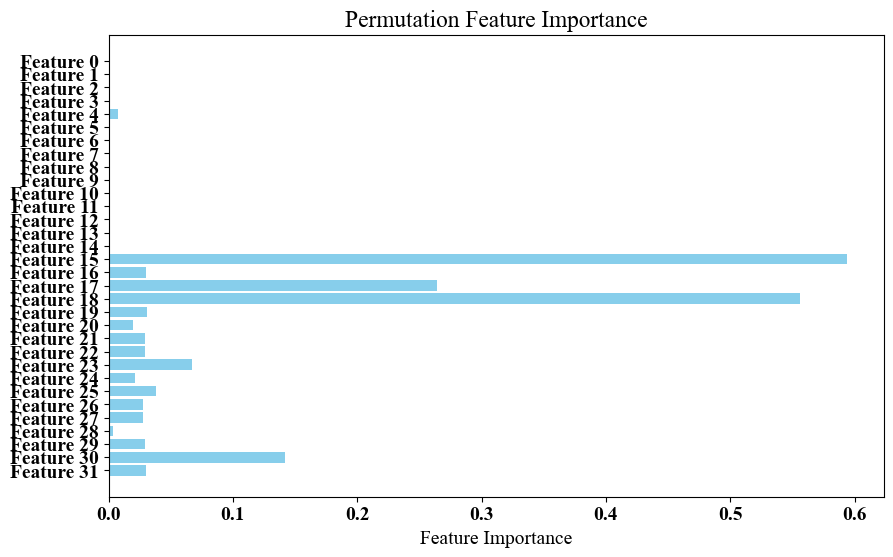

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR

# 假设 svr_model 是已经训练好的SVR模型，X_train 和 y_train 是你的数据

# 计算置换特征重要性
results = permutation_importance(ensemble_model, X_train, y_train, n_repeats=32, random_state=24)

# 获取特征的重要性
importances = results.importances_mean

# 获取特征名称（假设 X_train 的列名是特征的名称）
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制每个特征的重要性
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # 使得最重要的特征位于顶部
plt.show()

In [37]:
# 创建 DataFrame 保存特征名称和重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 将结果保存到 Excel 文件
importance_df.to_excel('feature_importance-3754.xlsx', index=False)

          col1  col2      col3      col4      col5      col6      col7  \
0     0.535833   0.0  0.160168  0.015447  0.260694  0.246617  0.294563   
1     0.535833   0.0  0.160168  0.015447  0.260694  0.246617  0.294563   
2     0.535833   0.0  0.160168  0.015447  0.260694  0.246617  0.294563   
3     0.535833   0.0  0.160168  0.015447  0.260694  0.246617  0.294563   
4     0.535833   0.0  0.160168  0.015447  0.260694  0.246617  0.294563   
...        ...   ...       ...       ...       ...       ...       ...   
2981  0.372893   0.0  0.044365  0.000000  0.000000  0.000000  0.000000   
2982  0.372893   0.0  0.044365  0.000000  0.000000  0.000000  0.000000   
2983  0.372893   0.0  0.044365  0.000000  0.000000  0.000000  0.000000   
2984  0.372893   0.0  0.044365  0.000000  0.000000  0.000000  0.000000   
2985  0.372893   0.0  0.044365  0.000000  0.000000  0.000000  0.000000   

          col8      col9  col10  ...    col23     col24     col25     col26  \
0     0.119823  0.169036    0.0 

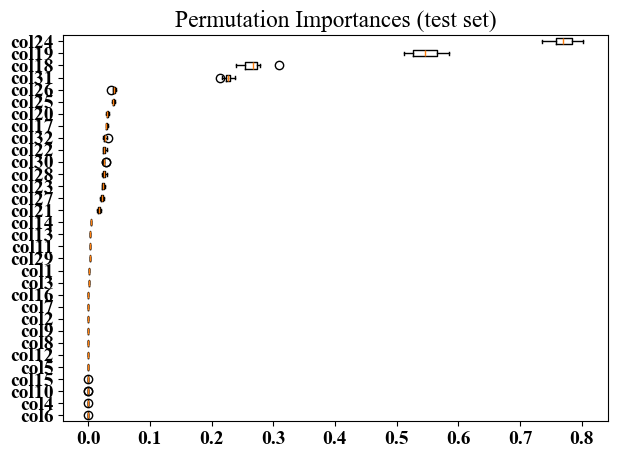

In [19]:
# 假设 X_train 是 numpy.ndarray，并且它有 32 列
columns = [f'col{i+1}' for i in range(32)]  # 生成一个列名列表 ['col1', 'col2', ..., 'col32']

# 创建 DataFrame
X_train = pd.DataFrame(X_train, columns=columns)
print(X_train)
result = permutation_importance(ensemble_model, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=8)
print(result)
sorted_idx = result.importances_mean.argsort()
print(sorted_idx)
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

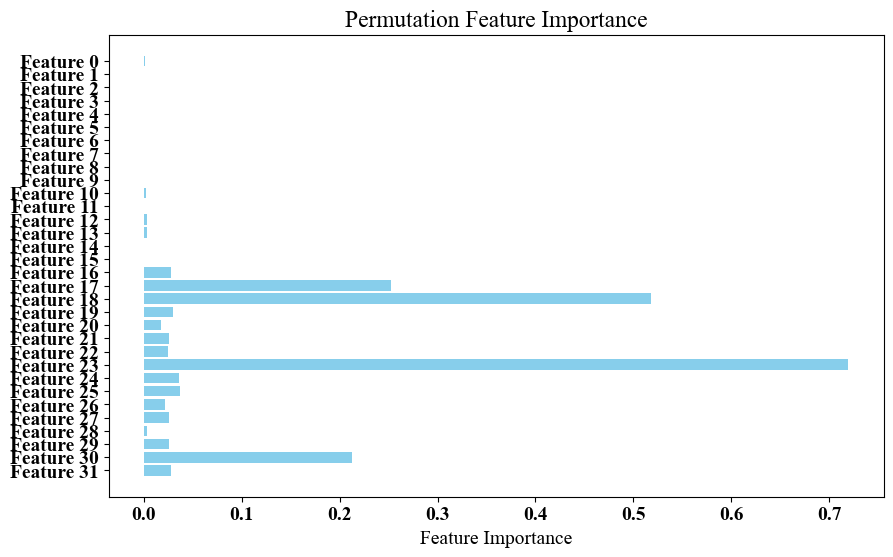

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR

# 假设 svr_model 是已经训练好的SVR模型，X_train 和 y_train 是你的数据

# 计算置换特征重要性
results = permutation_importance(ensemble_model, X_test, y_test, n_repeats=32, random_state=8)

# 获取特征的重要性
importances = results.importances_mean

# 获取特征名称（假设 X_train 的列名是特征的名称）
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制每个特征的重要性
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # 使得最重要的特征位于顶部
plt.show()

In [46]:
# 创建 DataFrame 保存特征名称和重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 将结果保存到 Excel 文件
importance_df.to_excel('feature_importance.xlsx', index=False)

In [42]:
from lime.lime_tabular import LimeTabularExplainer
model = ensemble_model
# 创建LIME解释器
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f'Feature {i}' for i in range(X_train.shape[1])],
    class_names=['Target'],
    mode='regression'
)

# 选择一个测试样本进行解释
idx = 10
explanation = explainer.explain_instance(X_test[idx], model.predict)

# 打印特征的重要性
explanation.show_in_notebook(show_table=True)

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn import ensemble

# 假设X是特征矩阵，y是目标值
# X, y = your_data

# 定义模型
models = {
    'XGBRegressor': XGBRegressor(max_depth=4, n_estimators=250, random_state=42, learning_rate=0.2, min_child_weight=4),
    'GradientBoostingRegressor': ensemble.GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=100, min_samples_split=5, random_state=42),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=20000, gamma=0.1),
    "ensemble_model":ensemble_model
}

# 定义十折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储结果的字典
results = {}

# 遍历每个模型
for model_name, model in models.items():
    # 进行十折交叉验证
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
    
    # 计算指标
    r2 = np.mean(scores['test_r2'])
    rmse = np.mean(np.sqrt(-scores['test_neg_mean_squared_error']))
    mae = np.mean(-scores['test_neg_mean_absolute_error'])
    
    # 存储每个模型的结果
    results[model_name] = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    }

# 将结果转换为DataFrame显示
results_df = pd.DataFrame(results).T
print(results_df)


                                 R2       RMSE        MAE
XGBRegressor               0.989682   5.148256   2.951905
GradientBoostingRegressor  0.989721   5.111921   3.044730
LinearRegression           0.661363  29.807575  16.163304
RandomForestRegressor      0.972219   8.451582   5.212220
SVR                        0.990447   4.917384   2.797775
